<h1 align='center'><font color="orange">The Rice is Right:</font></h1>
<h1 align='center'>Early Detection of Rice Leaf Disease using Convolutional Neural Networks</h1>

# Highlights

In the Philippines, rice farming industry is very dominant encompassing over 10 million Filipinos. However, these families earn as low as 10 pesos due to the current economy in the industry. Add this to the fact that 37\% of their production are lost due to pests and diseases.

This study aims to help farmers by early detection of disease through rice leaf image processing using convolutional neural networks. The model is trained on the Rice Disease Image Dataset by Huy Minh Do which includes over 3000 rice leaf images. Over 4 categories: Leaf Blast, Brown Spot, Hispa, and Healthy; the model performs well at 78.2\% accuracy. We also looked at how it performs on classifying a healthy rice leaf and found that the model performed even better at 92.2\%. Furthermore, we saw that the model is capable even for cases where the symptoms of the disease are still very small. This model gives farmers ample time to potentially save their crops, have better yield, and save cost from fertilizers and pesticides.

## Data

The data used for this project is [Rice Diseases Image Dataset](https://www.kaggle.com/minhhuy2810/rice-diseases-image-dataset/version/1?fbclid=IwAR3QwbQzFpHLe_KCelIbrrMB4kwaBfhzJhrcqLwX7DEOJmLfkI4ZRF2le4U) compiled by Huy Minh Do and uploaded in Kaggle. This consists of 3355 images of isolated rice leaves with four classifications: Healthy (1488) or afflicted with one of the diseases: Hispa (565), Brown Spot (523), or Leaf Blast (779). The image sizes range from 734 by 734 pixels to 3120 by 3120 pixels. Sample images of the dataset for each classification is shown in Figure 1. 

<img src='sampleimages.png'>
<div align='center'>Figure 1. Sample images of rice leaves per classification: Leaf Blast, Brown Spot, Hispa, and Healthy.</div>

## Data Pre-processing

Before any modeling or classification is performed on the images, several image pre-processing steps must be performed first. 

### Reshape

To account for any limitations that may arise due to camera specifications, all images are reshaped to 300 by 300 pixels, regardless of initial shape. In doing so, the model that will be trained in the succeeding parts will be applicable to even low-quality images. We use PIL for this.

In [ ]:
from PIL import Image
import glob

In [245]:
files = glob.glob('D://Users/Public/Documents/MSDS/Data/rice-diseases-image-dataset/LabelledRice/Labelled/*/*')

In [248]:
files_reshape = list(map(lambda x: x.replace('/Labelled\\', '/Resized\\'), files))

In [250]:
basewidth = 300
for file, file_save in zip(files, files_reshape):
    img = Image.open(file)
    wpercent = (basewidth/float(img.size[0]))
    hsize = int((float(img.size[1])*float(wpercent)))
    img = img.resize((basewidth,hsize), Image.ANTIALIAS)
    img.save(file_save) 


 To do this, a mask is created using the following steps:

### Background removal
After reshaping, the foreground of the image, i.e. the actual leaf, must be separated from the background to reduce noise and data leakage, which would then lead to easier model training. With this, we need to do automated background removal such that an actual photo not taken in an isolated environment can be classified properly by our model.

These are the steps taken to remove the background per image:

1. We first perform thresholding according to the RGB values. We want the green pixels and the area around it so we filter by taking out the pixels that have too high red and blue values. 

        1a. We start with 220 threshold (out of 255) and continuously reduce this threshold if the resulting mask image is too big (i.e. not much of the image has been filtered). 

2. From the resulting mask, we perform morphological techniques like opening so that the pixels in-between the green leaf pixels will be included into the mask (i.e. the brown spots which will most likely be filtered out will be included using the morphological technique). For this, we use a circular structuring element of radius 13px.

3. We perform erosion to increase the area of the mask in order for the filter to include the immediate surrounding pixels. Then a final closing operation was done to remove the isolated dots.

4. From the blobs formed, we select the largest one and use that as the mask for our actual image.

*erosion and opening was used and not dilation and closing since the foreground and background are reversed in the mask (the actual area we want to use has values of False and the backgroudn we want to remove has values of True)

In [17]:
from skimage.morphology import binary_closing, binary_opening, erosion

In [253]:
files_bgremoved = list(map(lambda x: x.replace('/Labelled\\', '/BGRemoved\\'), files))

In [254]:
selem = np.zeros((25, 25))

ci,cj=12, 12
cr=13

# Create index arrays to z
I,J=np.meshgrid(np.arange(selem.shape[0]),np.arange(selem.shape[1]))

# calculate distance of all points to centre
dist=np.sqrt((I-ci)**2+(J-cj)**2)

# Assign value of 1 to those points where dist<cr:
selem[np.where(dist<=cr)]=1

In [268]:
%matplotlib inline
import numpy as np
from scipy import ndimage

# fig, ax = plt.subplots(20,2, figsize=(10,80))
idx = 0
for file, file_save in zip(files, files_bgremoved):
    bg_frac = 0
    thres = 220
    img = Image.open(file)
    im_arr = np.array(img)
#     ax[idx, 0].imshow(im_arr)
    R = im_arr[:, :, 0]
    G = im_arr[:, :, 1]
    B = im_arr[:, :, 2]
    while bg_frac < 0.6: 
        bg_mask = ((R>thres) | (B>thres))# & (G < 100)
        bg_frac = bg_mask.sum()/len(bg_mask.flatten())
        thres -= 5
    # we use opening first since our mask is reversed (the foreground and background are reversed here)
    bg_mask = binary_closing(erosion(binary_opening(bg_mask, selem), np.ones((3, 3))), np.ones((5,5)))
    
    #Get biggest blob
    label, num_label = ndimage.label(~bg_mask)
    size = np.bincount(label.ravel())
    biggest_label = size[1:].argmax() + 1
    bg_mask = label == biggest_label
    
    im_arr[~bg_mask, 0] = 255
    im_arr[~bg_mask, 1] = 255
    im_arr[~bg_mask, 2] = 255
    
    img = Image.fromarray(im_arr)
    img.save(file_save)
    idx+=1

(array([83779.,  2307.,   865.,   781.,  1153.,   383.,   118.,    89.,
          148.,   377.]),
 array([  0. ,  25.5,  51. ,  76.5, 102. , 127.5, 153. , 178.5, 204. ,
        229.5, 255. ]),
 <a list of 10 Patch objects>)

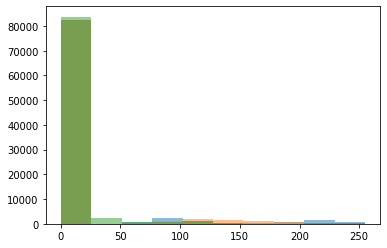

In [175]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.hist(R.flatten(), alpha=0.5)
plt.hist(G.flatten(), alpha=0.5)
plt.hist(B.flatten(), alpha=0.5)


### Data Augmentation

To account for different environments upon taking the picture, e.g. rotated images, shifted objects, zoomed in pictures, image augmentation is performed. The augmented images will be transformed versions of the dataset by randomly rotating the image up to 30$^\circ$, shifting the image vertically or horizontally up to 15% of the image length, shearing the image up to 20$^\circ$, and zooming in the image 0.8x to 1.2x.

In [7]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
import matplotlib.pyplot as plt
%matplotlib inline

base_dir = ('D://Users/Public/Documents/MSDS/Data/rice-diseases-image-dataset/LabelledRice/BGRemoved')
os.makedirs(base_dir, exist_ok=True)

In [8]:
datagen = ImageDataGenerator(
    rotation_range=30, width_shift_range=0.15,
    height_shift_range=0.15, shear_range=0.15, 
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest", validation_split=0.3)
batch_size = 32

train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training')

val_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation')

Found 2319 images belonging to 4 classes.
Found 991 images belonging to 4 classes.


## Modeling

For the modeling, we used different pre-trained models and one manually made model to classify the images. Six architectures were used for this project:

1. VGG16 base for feature extraction and 3-dense layers for classification.
2. VGG16 base with only the first 3 blocks frozen and 3-dense layers
3. VGG19 base and 3-dense layers
4. XCeption base and 3-dense layers
5. ResNet base and 3-dense layers
6. 5 convolutional layers and 2-dense layers

### VGG16

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

checkpoint = ModelCheckpoint('VGG16.h5', verbose=1, monitor='val_accuracy', save_best_only=True, mode='auto')  

In [9]:
datagen = ImageDataGenerator(
    rotation_range=30, width_shift_range=0.15,
    height_shift_range=0.15, shear_range=0.15, 
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest")
# datagen = ImageDataGenerator(rescale=1./255)

def extract_features(trainorval, sample_count):
    features = np.zeros(shape=(sample_count, 7, 7, 512))
    labels = np.zeros(shape=(sample_count, 4))
    if trainorval=="training":
        generator = train_generator
    else:
        generator = val_generator
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(preprocess_input(inputs_batch))
        try:
            features[i * batch_size : (i + 1) * batch_size] = features_batch
            labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        except ValueError:
            break
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels


In [10]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [11]:
conv_base.trainable = True
for layer in conv_base.layers:
    layer.trainable = True


In [12]:
train_features, train_labels = extract_features('training', 2319)
validation_features, validation_labels = extract_features('validation', 991)

train_features = np.reshape(train_features, (2319, 7 * 7 * 512))
validation_features = np.reshape(validation_features, (991, 7 * 7 * 512))

In [3]:
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=7 * 7 * 512))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.2))  #Removing 50% of the weights!
model.add(layers.Dense(4, activation='softmax'))

In [5]:
from tensorflow.keras.optimizers import Adam

INIT_LR = 1e-1
EPOCHS = 30

opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
# from tensorflow.keras.utils.vis_utils import plot_model
from tensorflow.keras.utils import plot_model
import os
os.environ["PATH"] += os.pathsep + 'C:\\Users\\1000246125\\AppData\\Local\\Continuum\\anaconda3\\Library\\bin'
model = Sequential()
model.add(Dense(2, input_dim=1, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


In [14]:
from tensorflow.keras.optimizers import Adam

INIT_LR = 1e-1
EPOCHS = 30

opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)

model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint('VGG16.h5', verbose=1, monitor='val_acc', save_best_only=True, mode='auto') 

history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=batch_size,
                    validation_data=(validation_features, validation_labels),
                    callbacks=[checkpoint])

Train on 2319 samples, validate on 991 samples
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Using TensorFlow backend.


Epoch 1/30
2272/2319 [============================>.] - ETA: 0s - loss: 6.3477 - acc: 0.5844
Epoch 00001: val_acc improved from -inf to 0.58426, saving model to VGG16.h5
2319/2319 [==============================] - 3s 1ms/sample - loss: 6.3451 - acc: 0.5846 - val_loss: 6.3937 - val_acc: 0.5843
Epoch 2/30
2272/2319 [============================>.] - ETA: 0s - loss: 6.3831 - acc: 0.5849
Epoch 00002: val_acc did not improve from 0.58426
2319/2319 [==============================] - 3s 1ms/sample - loss: 6.3964 - acc: 0.5841 - val_loss: 6.3937 - val_acc: 0.5843
Epoch 3/30
2272/2319 [============================>.] - ETA: 0s - loss: 6.3933 - acc: 0.5843
Epoch 00003: val_acc did not improve from 0.58426
2319/2319 [==============================] - 3s 1ms/sample - loss: 6.3964 - acc: 0.5841 - val_loss: 6.3937 - val_acc: 0.5843
Epoch 4/30
2272/2319 [============================>.] - ETA: 0s - loss: 6.3967 - acc: 0.5841
Epoch 00004: val_acc did not improve from 0.58426
2319/2319 [===============

### VGG16 (Frozen first 3)

In [81]:
datagen = ImageDataGenerator(
    rotation_range=30, width_shift_range=0.15,
    height_shift_range=0.15, shear_range=0.15, 
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest", validation_split=0.3)
batch_size = 32

train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training')

val_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation')

Found 2319 images belonging to 4 classes.
Found 991 images belonging to 4 classes.


In [84]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block4_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [99]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu', input_dim=7 * 7 * 512))
# model.add(layers.Dropout(0.2))
model.add(layers.Dense(128, activation='relu'))
# model.add(layers.Dropout(0.2))  #Removing 50% of the weights!
model.add(layers.Dense(4, activation='softmax'))

In [86]:
from tensorflow.keras.optimizers import Adam

INIT_LR = 1e-3
EPOCHS = 30

opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)

model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint('VGG16_frozen3.h5', verbose=1, monitor='val_acc', save_best_only=True, mode='auto') 

history = model.fit_generator(train_generator,
                    epochs=30,
                    steps_per_epoch=2319 // batch_size,
                    validation_data=val_generator,
                    callbacks=[checkpoint])

Epoch 1/30
71/72 [============================>.] - ETA: 6s - loss: 4.5213 - acc: 0.7051 
Epoch 00001: val_acc improved from -inf to 0.72200, saving model to VGG16_frozen4.h5
72/72 [==============================] - 550s 8s/step - loss: 4.5388 - acc: 0.7040 - val_loss: 4.2754 - val_acc: 0.7220
Epoch 2/30
71/72 [============================>.] - ETA: 5s - loss: 4.2951 - acc: 0.7206 
Epoch 00002: val_acc did not improve from 0.72200
72/72 [==============================] - 535s 7s/step - loss: 4.2922 - acc: 0.7208 - val_loss: 4.2761 - val_acc: 0.7220
Epoch 3/30
71/72 [============================>.] - ETA: 5s - loss: 4.2723 - acc: 0.7226 
Epoch 00003: val_acc did not improve from 0.72200
72/72 [==============================] - 535s 7s/step - loss: 4.2596 - acc: 0.7234 - val_loss: 4.2754 - val_acc: 0.7220
Epoch 4/30
71/72 [============================>.] - ETA: 5s - loss: 4.3019 - acc: 0.7202 
Epoch 00004: val_acc did not improve from 0.72200
72/72 [==============================] - 537s

### VGG19

In [9]:
datagen = ImageDataGenerator(
    rotation_range=30, width_shift_range=0.15,
    height_shift_range=0.15, shear_range=0.15, 
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest", validation_split=0.3)
batch_size = 32

train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training')

val_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation')

Found 2319 images belonging to 4 classes.
Found 991 images belonging to 4 classes.


In [17]:
def extract_features19(trainorval, sample_count):
    features = np.zeros(shape=(sample_count, 7, 7, 512))
    labels = np.zeros(shape=(sample_count, 4))
    if trainorval=="training":
        generator = train_generator
    else:
        generator = val_generator
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base19.predict(preprocess_input(inputs_batch))
        try:
            features[i * batch_size : (i + 1) * batch_size] = features_batch
            labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        except ValueError:
            break
        if i==0:
            print("one down")
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

In [18]:
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input

conv_base19 = VGG19(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))

In [21]:
train_features19, train_labels19 = extract_features19('training', 2319)
validation_features19, validation_labels19 = extract_features19('validation', 991)

train_features19 = np.reshape(train_features19, (2319, 7 * 7 * 512))
validation_features19 = np.reshape(validation_features19, (991, 7 * 7 * 512))

In [48]:
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=7 * 7 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))  #Removing 50% of the weights!
model.add(layers.Dense(4, activation='softmax'))

In [49]:
from tensorflow.keras.optimizers import Adam

INIT_LR = 1e-3
EPOCHS = 30

opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)

model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint('VGG19.h5', verbose=1, monitor='val_acc', save_best_only=True, mode='auto') 

history = model.fit(train_features19, train_labels19,
                    epochs=30,
                    batch_size=batch_size,
                    validation_data=(validation_features19, validation_labels19),
                    callbacks=[checkpoint])

Train on 2319 samples, validate on 991 samples
Epoch 1/30
2272/2319 [============================>.] - ETA: 0s - loss: 3.2541 - acc: 0.7797
Epoch 00001: val_acc improved from -inf to 0.72200, saving model to VGG19.h5
2319/2319 [==============================] - 6s 3ms/sample - loss: 3.2489 - acc: 0.7803 - val_loss: 4.2754 - val_acc: 0.7220
Epoch 2/30
2272/2319 [============================>.] - ETA: 0s - loss: 3.2890 - acc: 0.7870
Epoch 00002: val_acc did not improve from 0.72200
2319/2319 [==============================] - 3s 1ms/sample - loss: 3.3088 - acc: 0.7857 - val_loss: 4.3772 - val_acc: 0.6988
Epoch 3/30
2272/2319 [============================>.] - ETA: 0s - loss: 3.8938 - acc: 0.7447
Epoch 00003: val_acc did not improve from 0.72200
2319/2319 [==============================] - 3s 1ms/sample - loss: 3.8696 - acc: 0.7464 - val_loss: 4.2740 - val_acc: 0.7220
Epoch 4/30
2272/2319 [============================>.] - ETA: 0s - loss: 3.2188 - acc: 0.7931
Epoch 00004: val_acc did not 

### XCeption

In [28]:
datagen = ImageDataGenerator(
    rotation_range=30, width_shift_range=0.15,
    height_shift_range=0.15, shear_range=0.15, 
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest", validation_split=0.3)
batch_size = 32

train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training')

val_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation')

Found 2319 images belonging to 4 classes.
Found 991 images belonging to 4 classes.


In [29]:
from tensorflow.keras.applications.xception import Xception, preprocess_input

In [30]:
xception_base = Xception(weights='imagenet',
                         include_top=False, 
                         input_shape=(224, 224, 3))

In [31]:
# datagen = ImageDataGenerator(rescale=1./255)

def extract_features_xception(trainorval, sample_count):
    features = np.zeros(shape=(sample_count, 7, 7, 2048))
    labels = np.zeros(shape=(sample_count, 4))
    if trainorval=="training":
        generator = train_generator
    else:
        generator = val_generator
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = xception_base.predict(preprocess_input(inputs_batch))
        try:
            features[i * batch_size : (i + 1) * batch_size] = features_batch
            labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        except ValueError:
            break
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

In [32]:
train_features_x, train_labels_x = extract_features_xception('training', 2319)
validation_features_x, validation_labels_x = extract_features_xception('validation', 991)

train_features_x = np.reshape(train_features_x, (2319, 7 * 7 * 2048))
validation_features_x = np.reshape(validation_features_x, (991, 7 * 7 * 2048))

In [55]:
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=7 * 7 * 2048))
model.add(layers.Dropout(0.35))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.35))  #Removing 50% of the weights!
model.add(layers.Dense(4, activation='softmax'))

In [56]:
from tensorflow.keras.optimizers import Adam

INIT_LR = 1e-3
EPOCHS = 30

opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)

model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint('XCeption.h5', verbose=1, monitor='val_acc', save_best_only=True, mode='auto') 

history = model.fit(train_features_x, train_labels_x,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features_x, validation_labels_x),
                    callbacks=[checkpoint])

Train on 2319 samples, validate on 991 samples
Epoch 1/30
2300/2319 [============================>.] - ETA: 0s - loss: 4.1240 - acc: 0.7145
Epoch 00001: val_acc improved from -inf to 0.72402, saving model to XCeption.h5
2319/2319 [==============================] - 141s 61ms/sample - loss: 4.1254 - acc: 0.7144 - val_loss: 4.2110 - val_acc: 0.7240
Epoch 2/30
2300/2319 [============================>.] - ETA: 0s - loss: 4.3414 - acc: 0.7130
Epoch 00002: val_acc did not improve from 0.72402
2319/2319 [==============================] - 20s 9ms/sample - loss: 4.3390 - acc: 0.7132 - val_loss: 4.2754 - val_acc: 0.7220
Epoch 3/30
2300/2319 [============================>.] - ETA: 0s - loss: 4.2730 - acc: 0.7220
Epoch 00003: val_acc did not improve from 0.72402
2319/2319 [==============================] - 15s 6ms/sample - loss: 4.2745 - acc: 0.7219 - val_loss: 4.2754 - val_acc: 0.7220
Epoch 4/30
2300/2319 [============================>.] - ETA: 0s - loss: 4.2801 - acc: 0.7211
Epoch 00004: val_acc 

### ResNet

In [35]:
datagen = ImageDataGenerator(
    rotation_range=30, width_shift_range=0.15,
    height_shift_range=0.15, shear_range=0.15, 
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest", validation_split=0.3)
batch_size = 32

train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training')

val_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation')

Found 2319 images belonging to 4 classes.
Found 991 images belonging to 4 classes.


In [36]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

In [37]:
resnet_base = ResNet50(weights='imagenet',
                         include_top=False,
                         input_shape=(224, 224, 3))

C:\Users\Justin\Anaconda3\envs\tf-gpu\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [40]:
def extract_features_resnet(trainorval, sample_count):
    features = np.zeros(shape=(sample_count, 7, 7, 2048))
    labels = np.zeros(shape=(sample_count, 4))
    if trainorval=="training":
        generator = train_generator
    else:
        generator = val_generator
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = resnet_base.predict(preprocess_input(inputs_batch))
        try:
            features[i * batch_size : (i + 1) * batch_size] = features_batch
            labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        except ValueError:
            break
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

In [52]:
train_features_res, train_labels_res = extract_features_resnet('training', 2319)
validation_features_res, validation_labels_res = extract_features_resnet('validation', 991)

train_features_res = np.reshape(train_features_res, (2319, 7 * 7 * 2048))
validation_features_res = np.reshape(validation_features_res, (991, 7 * 7 * 2048))

In [60]:
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=7 * 7 * 2048))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.4))  #Removing 50% of the weights!
model.add(layers.Dense(4, activation='softmax'))

In [61]:
from tensorflow.keras.optimizers import Adam

INIT_LR = 1e-3
EPOCHS = 30

opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)

model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint('ResNet.h5', verbose=1, monitor='val_acc', save_best_only=True, mode='auto') 


history = model.fit(train_features_res, train_labels_res,
                    epochs=30,
                    batch_size=batch_size,
                    validation_data=(validation_features_res, validation_labels_res),
                    callbacks=[checkpoint])

Train on 2319 samples, validate on 991 samples
Epoch 1/30
2304/2319 [============================>.] - ETA: 0s - loss: 0.6092 - acc: 0.9774
Epoch 00001: val_acc improved from -inf to 0.57820, saving model to ResNet.h5
2319/2319 [==============================] - 18s 8ms/sample - loss: 0.6071 - acc: 0.9776 - val_loss: 6.4868 - val_acc: 0.5782
Epoch 2/30
2304/2319 [============================>.] - ETA: 0s - loss: 0.6308 - acc: 0.9766
Epoch 00002: val_acc did not improve from 0.57820
2319/2319 [==============================] - 10s 4ms/sample - loss: 0.6286 - acc: 0.9767 - val_loss: 6.4868 - val_acc: 0.5782
Epoch 3/30
2304/2319 [============================>.] - ETA: 0s - loss: 0.6288 - acc: 0.9768
Epoch 00003: val_acc did not improve from 0.57820
2319/2319 [==============================] - 10s 4ms/sample - loss: 0.6266 - acc: 0.9769 - val_loss: 6.4868 - val_acc: 0.5782
Epoch 4/30
2304/2319 [============================>.] - ETA: 0s - loss: 0.6224 - acc: 0.9772
Epoch 00004: val_acc did 

### 5Conv2Dense

In [3]:
import numpy as np
import pickle
import cv2
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array, load_img
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
EPOCHS = 30
INIT_LR = 1e-3
BS = 16
default_image_size = tuple((256, 256))
image_size = 0
directory_root = 'D://Users/Public/Documents/MSDS/Data/rice-diseases-image-dataset/LabelledRice/BGRemoved'
width=256
height=256
depth=3

In [3]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [4]:
image_list, label_list = [], []
try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)
    for directory in root_dir :
        # remove .DS_Store from list
        if directory == ".DS_Store" :
            root_dir.remove(directory)

    for disease_folder in root_dir :
        plant_disease_image_list = listdir(f"{directory_root}/{disease_folder}")
        
        for image in plant_disease_image_list:
            image_directory = f"{directory_root}/{disease_folder}/{image}"
            if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                image_list.append(convert_image_to_array(image_directory))
                label_list.append(disease_folder)
    print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error : {e}")

[INFO] Loading images ...
[INFO] Image loading completed


In [5]:
image_size = len(image_list)
print(image_size)

3310


In [6]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

In [7]:
print(label_binarizer.classes_)

['BrownSpot' 'Healthy' 'Hispa' 'LeafBlast']


In [8]:
np_image_list = np.array(image_list, dtype=np.float16) / 225.0

In [9]:
print("[INFO] Spliting data to train, test")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.30, random_state = 42) 

[INFO] Spliting data to train, test


In [10]:
aug = ImageDataGenerator(
    rotation_range=30, width_shift_range=0.15,
    height_shift_range=0.15, shear_range=0.15, 
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest")

In [11]:
model = Sequential()
inputShape = (height, width, depth)
chanDim = -1
if K.image_data_format() == "channels_first":
    inputShape = (depth, height, width)
    chanDim = 1
model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(256))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(n_classes))
model.add(Activation("softmax"))

In [13]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 256, 256, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 256, 256, 32)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 256, 256, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 85, 85, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 85, 85, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 85, 85, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 85, 85, 64)       

In [12]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
# distribution
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])
# train the network
print("[INFO] training network...")

[INFO] training network...


In [13]:
from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint('best_model_5conv2dense_woutBG.h5', verbose=1, monitor='val_accuracy', save_best_only=True, mode='auto') 

In [14]:
history = model.fit_generator(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=EPOCHS, verbose=1,
    callbacks=[checkpoint]
    )

Epoch 1/30
144/144 [==============================] - 52s 362ms/step - loss: 0.7391 - accuracy: 0.6913 - val_loss: 4.9252 - val_accuracy: 0.5901

Epoch 00001: val_accuracy improved from -inf to 0.59013, saving model to best_model_5conv2dense_woutBG.h5
Epoch 2/30
144/144 [==============================] - 39s 273ms/step - loss: 0.6358 - accuracy: 0.7182 - val_loss: 2.4550 - val_accuracy: 0.6183

Epoch 00002: val_accuracy improved from 0.59013 to 0.61833, saving model to best_model_5conv2dense_woutBG.h5
Epoch 3/30
144/144 [==============================] - 39s 273ms/step - loss: 0.5616 - accuracy: 0.7363 - val_loss: 0.5656 - val_accuracy: 0.7326

Epoch 00003: val_accuracy improved from 0.61833 to 0.73263, saving model to best_model_5conv2dense_woutBG.h5
Epoch 4/30
144/144 [==============================] - 39s 274ms/step - loss: 0.5074 - accuracy: 0.7602 - val_loss: 0.9816 - val_accuracy: 0.6067

Epoch 00004: val_accuracy did not improve from 0.73263
Epoch 5/30
144/144 [=================

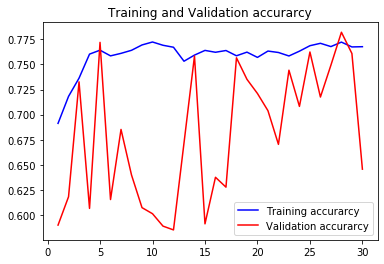

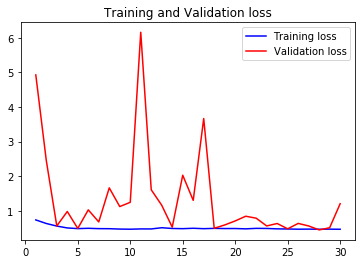

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [16]:
# model = model.load('best_model_5conv2dense.h5')
from keras.models import load_model
from keras.models import model_from_json

json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])

# load weights into new model
loaded_model.load_weights("best_model_5conv2dense_woutBG.h5")

In [17]:
print("[INFO] Calculating model accuracy")
scores = loaded_model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
993/993 [==============================] - 5s 5ms/step
Test Accuracy: 78.19738388061523


### Looking at each type of leaf:

In [18]:
scores_brownspot = loaded_model.evaluate(x_test[y_test[:,0]==1], y_test[y_test[:,0]==1])
print(f"Test Accuracy: {scores_brownspot[1]*100}")

179/179 [==============================] - 1s 7ms/step
Test Accuracy: 85.33519506454468


In [19]:
scores_healthy = loaded_model.evaluate(x_test[y_test[:,1]==1], y_test[y_test[:,1]==1])
print(f"Test Accuracy: {scores_healthy[1]*100}")

432/432 [==============================] - 2s 5ms/step
Test Accuracy: 92.1875


In [20]:
scores_hispa = loaded_model.evaluate(x_test[y_test[:,2]==1], y_test[y_test[:,2]==1])
print(f"Test Accuracy: {scores_hispa[1]*100}")

148/148 [==============================] - 1s 7ms/step
Test Accuracy: 54.39189076423645


In [21]:
scores_leafblast = loaded_model.evaluate(x_test[y_test[:,3]==1], y_test[y_test[:,3]==1])
print(f"Test Accuracy: {scores_leafblast[1]*100}")

234/234 [==============================] - 1s 6ms/step
Test Accuracy: 61.965811252593994


## Results


Training all the models discussed with the processed images, the accuracy of each model on a validation set is shown in Table 1. Comparing the different models, the model trained from top to bottom yielded the highest accuracy at 78.2%.


<!-- \begin{table}[]
\begin{tabular}{ll} -->

| Base model                                      | Accuracy |
|----|----|
|VGG16 | 58.4\% | 
|VGG16 (with first three blocks are frozen) | 72.2\%  |
|VGG19                                           | 72.4\%   |
|XCeption                                        | 72.2\%   |
|ResNet50                                        | 72.2\%   |
|5-layer convolution                             | 78.2\%  |


Looking further into the best model and how well it predicts each class, an 85.3% accuracy was found for brown spot, 54.4% for hispa, and 62.0% for leaf blast. On the other hand for healthy rice leaves, it was classified accurately 92.2% of the time. From this, discrepancies on prediction power of the model to different classifications can be observed. Except for brown spots, the model only accurately predicts more than half of rice leaves with disease. 

This can be attributed to the dataset used wherein the progression of the disease on the leaves were at its initial stages, so the symptoms are not that developed yet. While the model suffers from relatively low accuracy because of this, the power to predict disease at an earlier stage would give the farmers the opportunity to treat the diseases even before it spreads. This would save them time and energy that they have limited amount of and allow them to focus on the growth of their crops with less worries. That said, seeing how effective the model is on predicting if healthy rice leaves are actually healthy, it can prevent farmers from unnecessarily providing treatment when the plants are actually healthy.

## Conclusions and Recommendations

Three different classifications of rice leaf diseases were studied and compared with the healthy rice leaf using the convolutional neural network. Using more than 3000 images as training data and different image pre-processing techniques, we were able to identify what type of disease a leaf has with 78.2\% accuracy. Diving deeper, we can accurately classify a healthy leaf as healthy which would aid the farmers save resources by not treating the already healthy plants.

For future studies, we recommend to improve the accuracy of prediction by exploring other network architecture or adding layers or nodes to the current model, scale the project to other diseases for the model to be more general, and, lastly, consult with farmers and consider their input into the pre-processing and deployment of the model.


## Acknowledgements

  The authors would like to acknowledge our Machine Learning 2.0 professors, Prof. Christopher Monterola, and Prof. Erika Legara for all their guidance and support for the completion of this project. 